---

Gaussian Mixture Models (GMMs)

---

# Imports

In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import chi2, multivariate_normal

sns.set_theme("talk")
mpl.rcParams["figure.figsize"] = (8, 6)

# Load data

[Old Faithful dataset](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/faithful.html)

- Description
    - Waiting time between eruptions and the duration of the eruption for the 
    Old Faithful geyser in Yellowstone National Park, Wyoming, USA.
- Format
    - A data frame with 272 observations on 2 variables.
        - eruptions: numeric, the eruption time (in minutes)
        - waiting: numeric, the waiting time to the next eruption (in minutes)

In [3]:
df = pd.read_csv("data/old_faithful.csv", index_col=0)

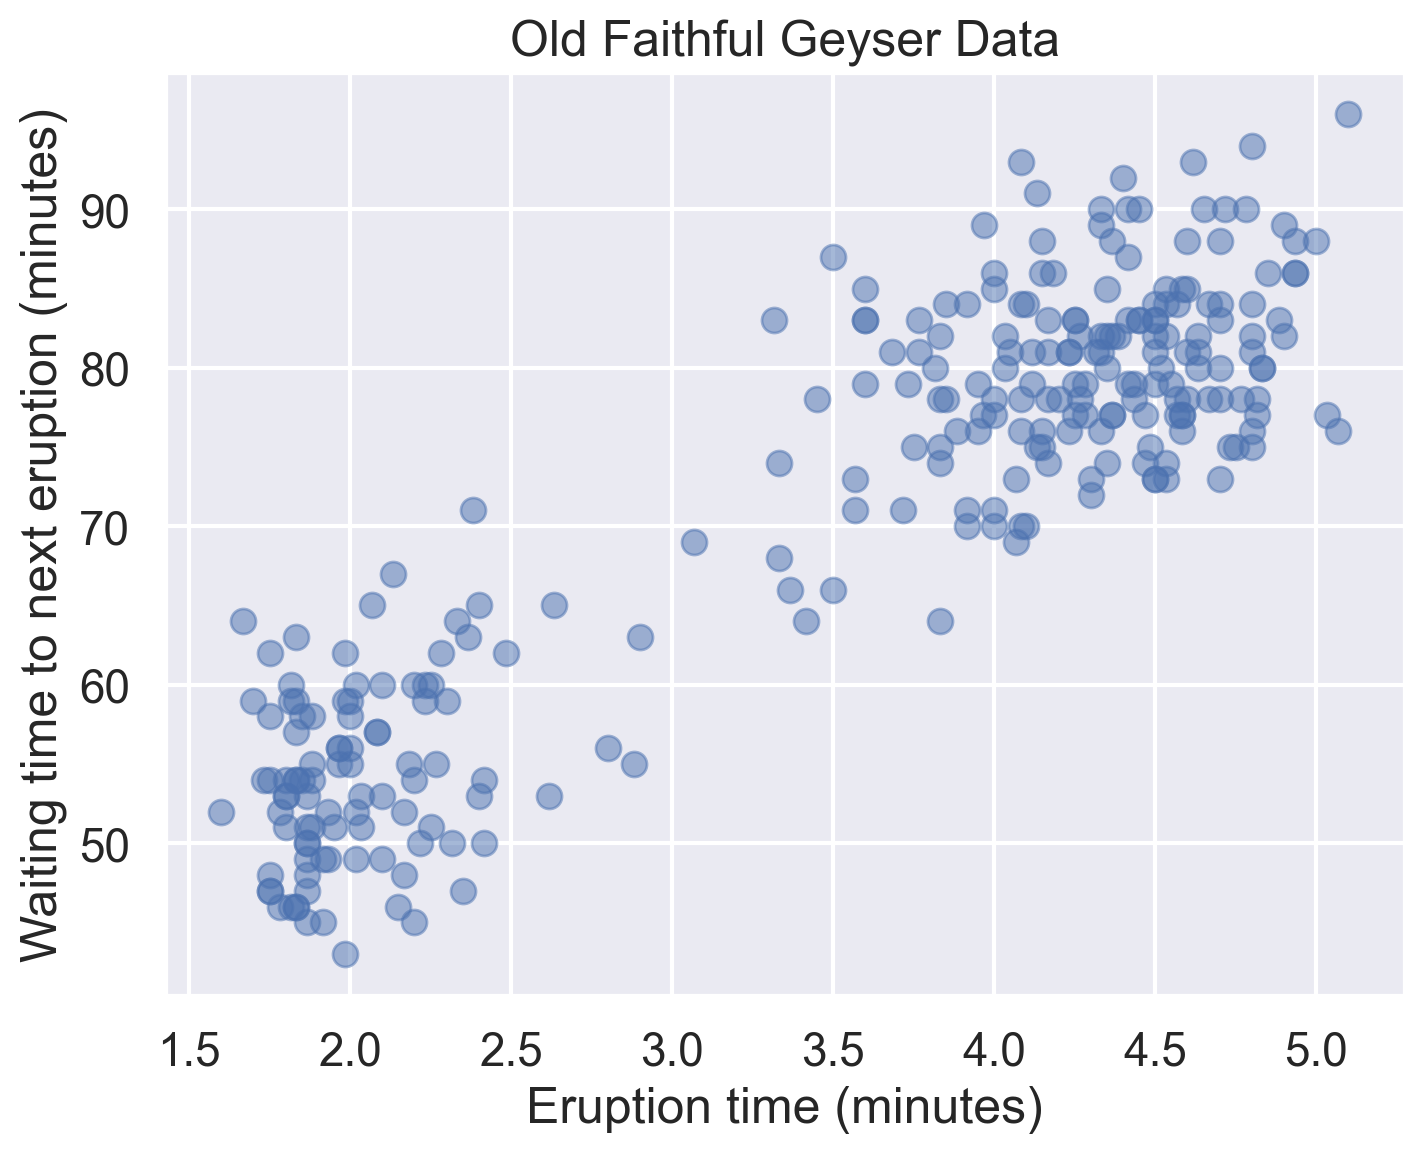

In [4]:
fig, ax = plt.subplots()
ax.plot(df["eruptions"], df["waiting"], "o", alpha=0.5)
ax.set_xlabel("Eruption time (minutes)")
ax.set_ylabel("Waiting time to next eruption (minutes)")
ax.set_title("Old Faithful Geyser Data")
plt.show()

In [5]:
data = df.to_numpy()

In [6]:
mean_estim, cov_estim = multivariate_normal.fit(data)

Contour plot

In [7]:
x = np.linspace(data[:, 0].min(), data[:, 0].max(), 200)
y = np.linspace(data[:, 1].min(), data[:, 1].max(), 200)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
Z = multivariate_normal.pdf(pos, mean=mean_estim, cov=cov_estim)

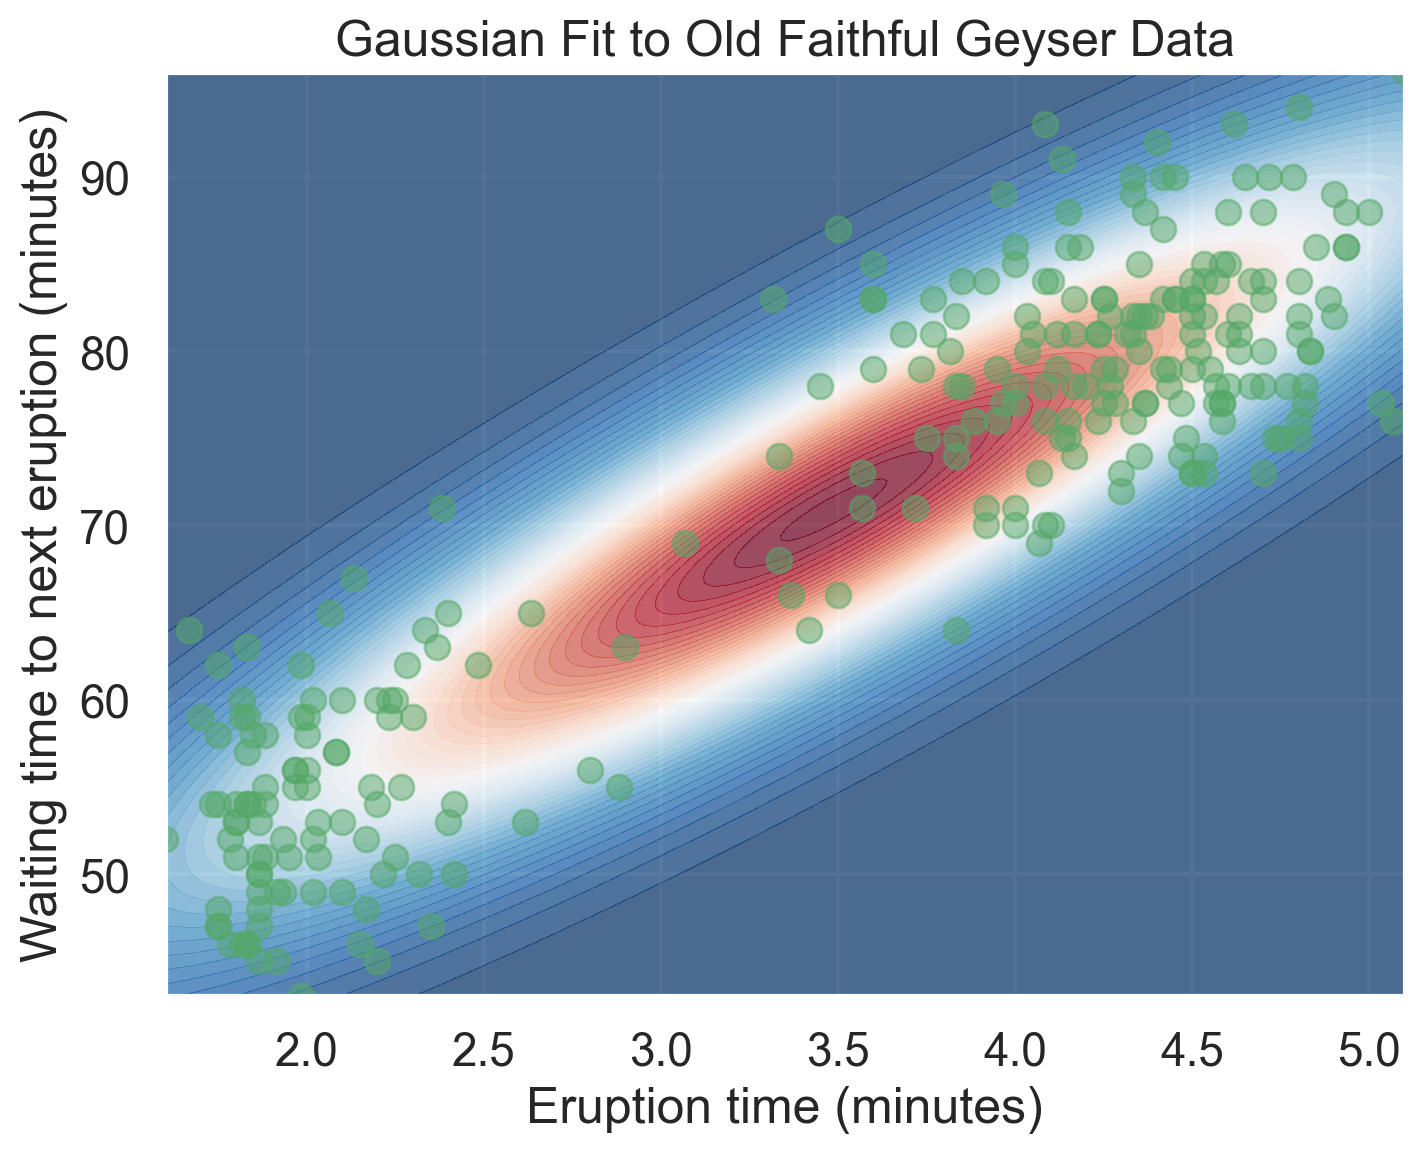

In [8]:
fig, ax = plt.subplots()
ax.contourf(X, Y, Z, levels=50, cmap="RdBu_r", alpha=0.7)
ax.plot(data[:, 0], data[:, 1], "go", alpha=0.5)
ax.set_xlabel("Eruption time (minutes)")
ax.set_ylabel("Waiting time to next eruption (minutes)")
ax.set_title("Gaussian Fit to Old Faithful Geyser Data")
plt.show()

Another contour plot

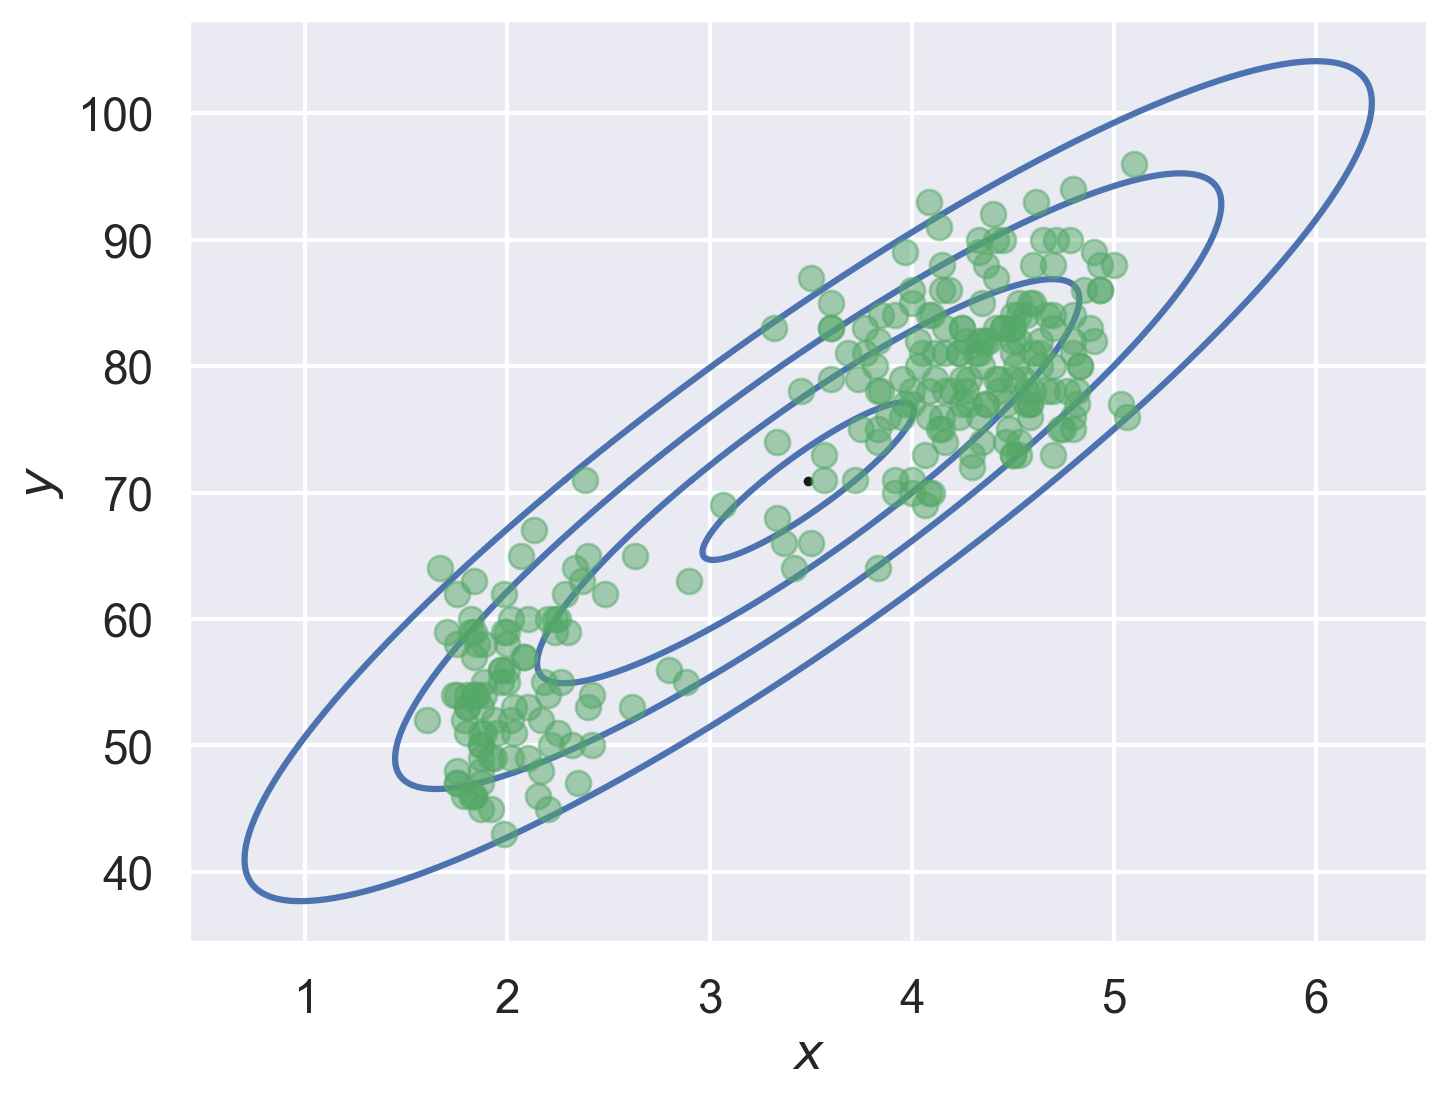

In [ ]:
# ellipse "radii" for chosen enclosed probabilities
probs = [0.1, 0.50, 0.80, 0.95]
cs = chi2.ppf(probs, df=2)  # c-values for the Mahalanobis distance^2

# eigen-decomposition
lam, V = np.linalg.eigh(cov_estim)  # lam: eigenvalues (>=0), V: eigenvectors (columns)
L = V @ np.diag(np.sqrt(lam))  # linear map turning unit circle -> 1-sigma ellipse

# parametric unit circle
theta = np.linspace(0, 2 * np.pi, 400)
unit = np.vstack((np.cos(theta), np.sin(theta)))  # shape (2, 400)

fig, ax = plt.subplots()
for p, c in zip(probs, cs, strict=True):
    # scale by sqrt(c) to get the desired ellipse
    ellipse = mean_estim.reshape(2, 1) + np.sqrt(c) * (L @ unit)
    ax.plot(ellipse[0], ellipse[1], "b-", label=f"{int(100 * p)}% probability")

ax.plot(mean_estim[0], mean_estim[1], ".k", ms=5)  # plot mean
ax.plot(data[:, 0], data[:, 1], "go", alpha=0.5)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
plt.show()

In [10]:
from stats.gaussian_mixtures import gaussian_mixture_pdf

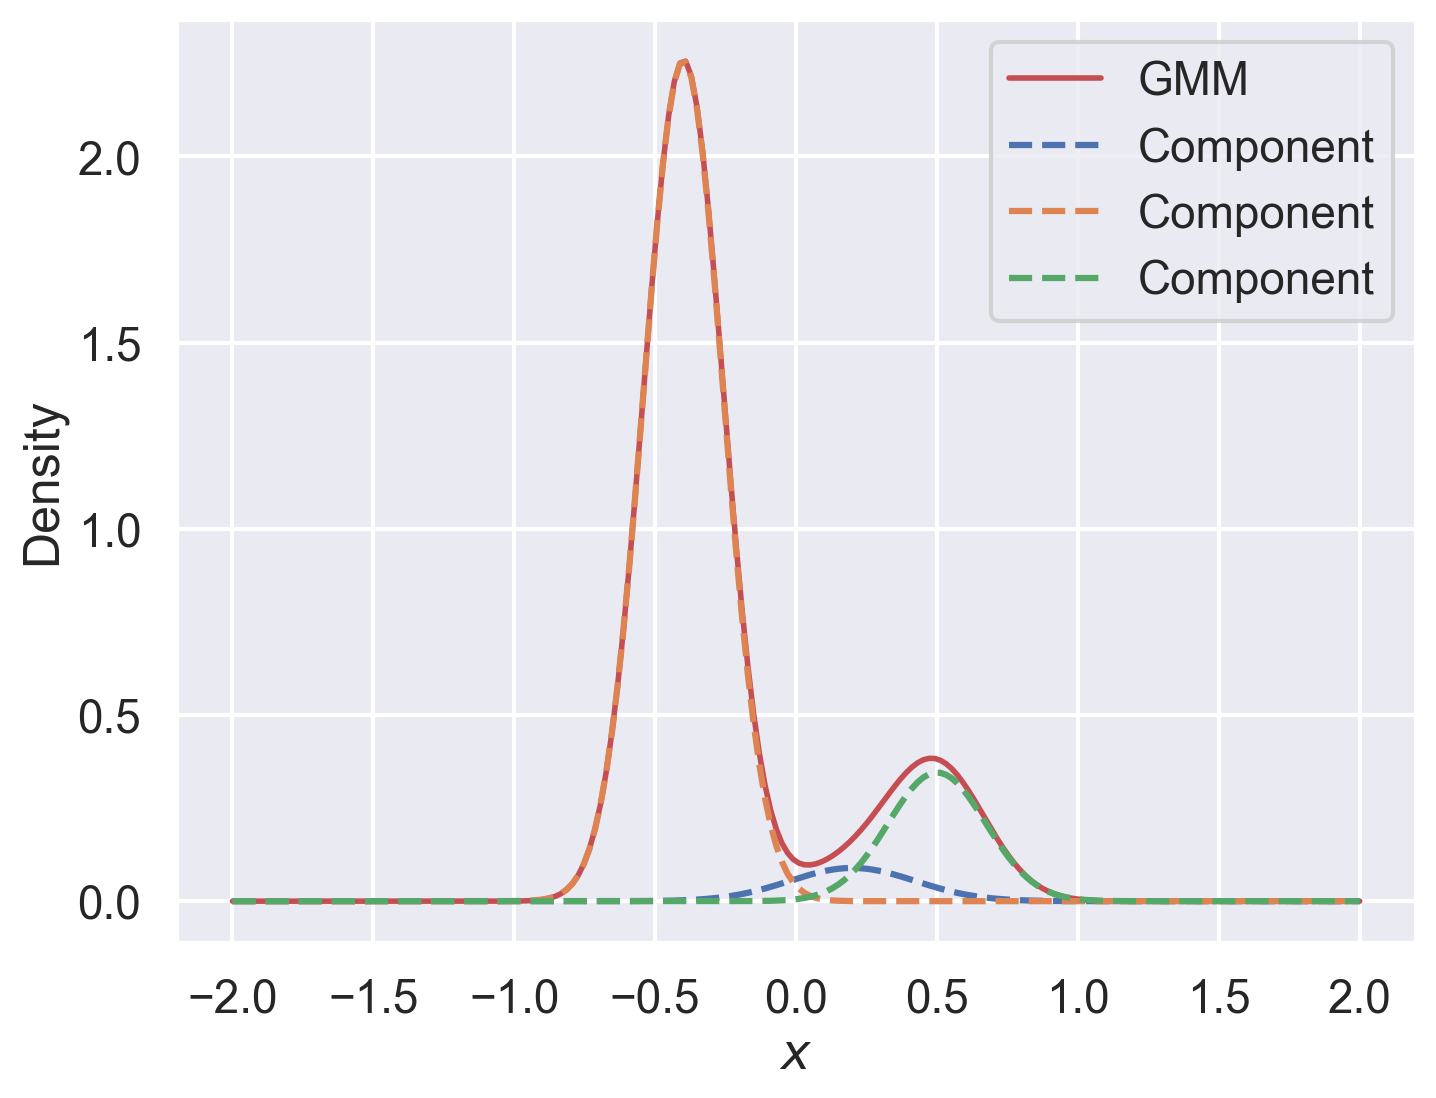

In [11]:
weights = np.array([0.05, 0.8, 0.15]).reshape(-1, 1)
means = np.array([0.2, -0.4, 0.5]).reshape(-1, 1)
covariances = np.array([0.05, 0.02, 0.03]).reshape(-1, 1, 1)


xs = np.linspace(-2, 2, 200)
pdf_mix = gaussian_mixture_pdf(xs, weights, means, covariances)
fig, ax = plt.subplots()
ax.plot(xs, pdf_mix, "r-", lw=2, label="GMM")
for w, m, c in zip(weights, means, covariances, strict=True):
    pdf_comp = w * multivariate_normal.pdf(xs, mean=m.ravel(), cov=c.ravel())
    ax.plot(xs, pdf_comp, "--", label="Component")
ax.set_xlabel("$x$")
ax.set_ylabel("Density")
ax.legend()
plt.show()

## Expectation-Maximization (EM) algorithm for GMMs

- Step 1: Initialize the parameters (means, covariances, and mixture weights) of the Gaussian components and compute the initial log-likelihood.
- Step 2: E-step: Compute the responsibilities (posterior probabilities) for each data point belonging to each Gaussian component.
- Step 3: M-step: Update the parameters of the Gaussian components using the responsibilities computed in the E-step.
- Step 4: Compute the log-likelihood of the data given the current parameters.
- Step 5: Check for convergence (e.g., if the change in log-likelihood is below a certain threshold). If not converged, return to Step 2.

In [106]:
mean_0 = np.array([1.5, 70])
mean_1 = np.array([4, 80])
means = np.array([mean_0, mean_1]).reshape(2, 2)

cov_0 = np.array([[0.2, 2], [2, 40]])
cov_1 = np.array([[0.5, 4], [3, 40]])
covariances = np.array([cov_0, cov_1])

weight_0 = 0.5
weight_1 = 0.5
weights = np.array([weight_0, weight_1]).reshape(-1, 1)

x_data = df.to_numpy()

weights_pdfs = np.array(
    [
        weights[i] * multivariate_normal.pdf(x_data, mean=means[i], cov=covariances[i])
        for i in range(len(weights))
    ]
)  # shape (n_components, n_samples)
loglik = np.sum(np.log(np.sum(weights_pdfs, axis=0)))

In [110]:
TOL = 1e-8
n_steps = 10

for i in range(n_steps):
    # 1) EM initialization - compute log-likelihood

    print(f"Step {i}: log-likelihood is {loglik:.2f}")

    # 2) E-step - compute responsibilities
    resp = weights_pdfs / np.sum(weights_pdfs, axis=0)

    # 3) M-step - update parameters
    N_k = np.sum(resp, axis=1).reshape(-1, 1)
    weights_new = N_k / x_data.shape[0]
    means_new = (resp @ x_data) / N_k
    covariances_new = np.array(
        [
            (
                (resp[i].reshape(-1, 1) * (x_data - means_new[i])).T
                @ (x_data - means_new[i])
            )
            / N_k[i]
            for i in range(len(weights))
        ]
    )
    weights_pdfs = np.array(
        [
            weights_new[i]
            * multivariate_normal.pdf(x_data, mean=means_new[i], cov=covariances_new[i])
            for i in range(len(weights_new))
        ]
    )  # shape (n_components, n_samples)
    loglik_new = np.sum(np.log(np.sum(weights_pdfs, axis=0)))
    # if np.abs(loglik_new - loglik) < TOL:
    #     print("Converged!")
    #     break

    weights, means, covariances, loglik = (
        weights_new,
        means_new,
        covariances_new,
        loglik_new,
    )

Step 0: log-likelihood is -1259.95
Step 1: log-likelihood is -1259.95
Step 2: log-likelihood is -1237.53
Step 3: log-likelihood is -1215.64
Step 4: log-likelihood is -1202.07
Step 5: log-likelihood is -1190.25
Step 6: log-likelihood is -1174.83
Step 7: log-likelihood is -1156.38
Step 8: log-likelihood is -1142.40
Step 9: log-likelihood is -1135.50


In [ ]:
print("Optimal parameters:\n")
print("weights:", weights.ravel(), "\n")
print("means:", means, "\n")
print("covariances:", covariances)

Optimal parameters:

weights: [0.34871428 0.65128572] 

means: [[ 2.01979914 54.37298064]
 [ 4.27377756 79.74445401]] 

covariances: [[[ 0.05668124  0.35957038]
  [ 0.35957038 33.45121516]]

 [[ 0.19092399  1.24860321]
  [ 1.24860321 40.35686331]]]


(array([[ 2.03652149, 54.47986018],
        [ 4.28977944, 79.96953298]]),
 array([[[ 0.06927449,  0.43627723],
         [ 0.43627723, 33.70493352]],
 
        [[ 0.16982046,  0.93871793],
         [ 0.93871793, 36.02497019]]]),
 array([0.35592745, 0.64407255]))

In [114]:
x = np.linspace(data[:, 0].min(), data[:, 0].max(), 200)
y = np.linspace(data[:, 1].min(), data[:, 1].max(), 200)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
Z = sum(
    multivariate_normal.pdf(pos, mean=mean_estim, cov=cov_estim)
    for mean_estim, cov_estim in zip(means, covariances)
)

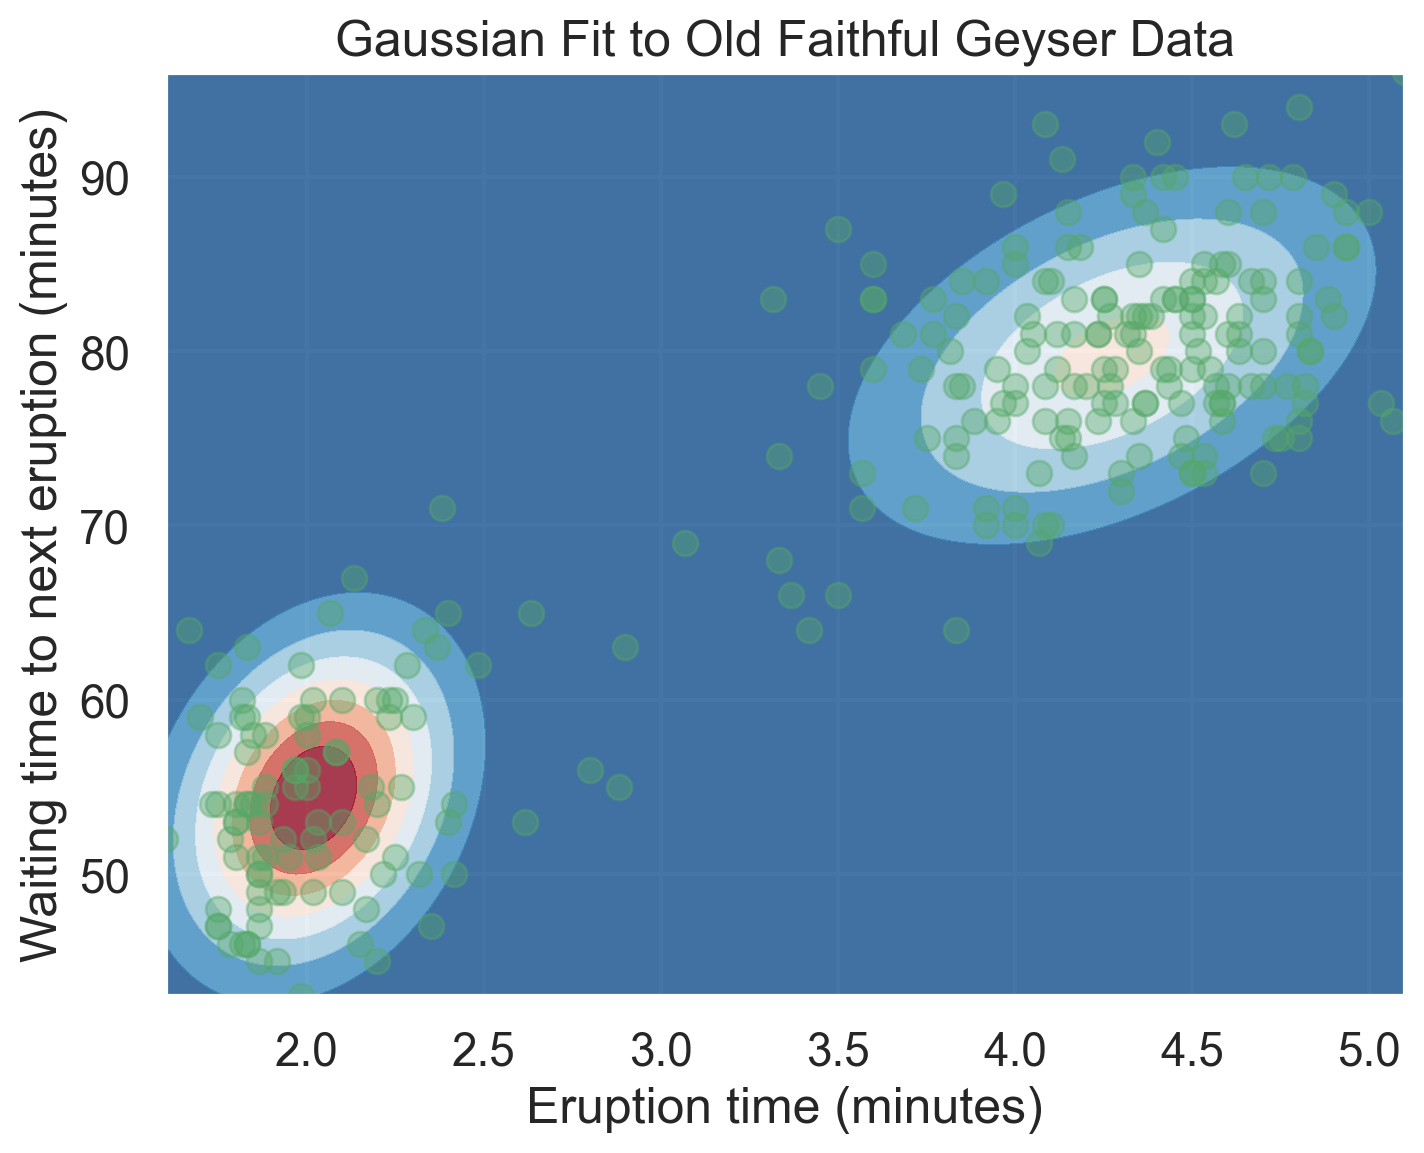

In [ ]:
fig, ax = plt.subplots()
ax.plot(x_data[:, 0], x_data[:, 1], "go", alpha=0.4)
ax.contourf(X, Y, Z, levels=10, cmap="RdBu_r", alpha=0.8)
ax.set_xlabel("Eruption time (minutes)")
ax.set_ylabel("Waiting time to next eruption (minutes)")
ax.set_title("Gaussian Fit to Old Faithful Geyser Data")
plt.show()

We can compare our results to the [GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) implementation from `sklearn`.

In [ ]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2, random_state=0).fit(x_data)
gm.means_, gm.covariances_, gm.weights_